In [1]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=32, optimizer_generator = SGD(0.00005, momentum=.9), 
                optimizer_discriminator = SGD(0.00005, momentum=.9), optimizer_autoencoder = Adam(0.0001)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, \
                self.discriminator2, self.generator, self.generator2 = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        #encoder.add(GlobalAvgPool3D())
        encoder.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(Flatten())
        encoder.add(Dense(512, activation="relu"))
        encoder.add(Dropout(0.3))
        encoder.add(Dense(512, activation="relu"))
        encoder.add(Dropout(0.3))
        encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
        decoder.add(Dense(1024, activation='relu', input_dim=encoded_dim))
        decoder.add(Dropout(0.3))
        decoder.add(Dense(1024, activation='relu'))
        decoder.add(Dropout(0.3))
        decoder.add(Dense(6*12*12, activation='relu'))
        decoder.add(Dropout(0.3))
        #decoder.add(Reshape([12*24*24,1]))
        #decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
        #decoder.add(Permute((2,1)))
        decoder.add(Reshape([6,12,12,1]))
        decoder.add(Conv3DTranspose(filters=128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(1024, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(1024, activation="relu"))
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator
    
    def _buildDiscriminator2(self, img_shape):
        
        discriminator = Sequential()
        discriminator.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        #discriminator.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        discriminator.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        discriminator.add(GlobalAvgPool3D())
        #discriminator.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(Flatten())
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))
        
        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape) # this is the input for autoencoder and main generator
        decoder_input=Input(shape=encoded_dim)
        
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mse")

        discriminator=self._buildDiscriminator(encoded_dim)
        discriminator.trainable = False
        generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
        generator.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator.trainable = True
        discriminator.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
    
        discriminator2 = self._buildDiscriminator2(img_shape)
        discriminator2.trainable = False
        generator2=Model(autoencoder_input, discriminator2(autoencoder(autoencoder_input)))
        generator2.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator2.trainable = True
        discriminator2.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
        
        return encoder, decoder, autoencoder, discriminator, discriminator2, generator, generator2

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        discriminator2_losses = []
        generator_losses = []
        generator2_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            fake_image = self.decoder.predict(fake_latent)
            
            discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
            discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator2_input = np.concatenate((fake_image, x))
            discriminator2_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history=0
            generator_history=0
            
            #discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            #generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            discriminator2_history = self.discriminator2.train_on_batch(discriminator2_input, discriminator2_labels)
            generator2_history = self.generator2.train_on_batch(x, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            discriminator2_losses.append(discriminator2_history)
            generator_losses.append(generator_history)
            generator2_losses.append(generator2_history)
            
            if epoch == 1:
                loss_min = autoencoder_history
                loss_min_epoch = 1
            
            if epoch > 5 and autoencoder_history < loss_min:
                loss_min = autoencoder_history
                loss_min_epoch = epoch
                self.autoencoder.save("../GAN_log/autoencoder_epoch_{}.h5".format(epoch))
                #self.discriminator.save("../GAN_log/discriminator_epoch_{}.h5".format(epoch))
                
            
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  AE_loss_min: {:.4f}  D1_loss:{:.3f}   D2_loss:{:.3f}   G1_loss:{:.3f}   G2_loss:{:.3f}".format(
                autoencoder_history, loss_min, discriminator_history, discriminator2_history, generator_history, generator2_history
                )
            )

        self.history = {
                        'AE_loss':autoencoder_losses, 
                        'D1_loss':discriminator_losses, 
                        'D2_loss':discriminator2_losses, 
                        'G1_loss':generator_losses,
                        'G2_loss':generator2_losses
                       }
        print("Min_loss at epoch: {}".format(loss_min_epoch))
        print("Best model saved at: ../GAN_log/autoencoder_epoch_{}.h5".format(loss_min_epoch))
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [55]:
import os
import SimpleITK as sitk 

datapath = r'../Data'
file_reference = r'../Training/File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

100%|██████████| 1198/1198 [00:08<00:00, 134.35it/s]


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

model = AAE(encoded_dim=256)

batch_size=24
n_epochs=6000
seed=42
np.random.seed(42)

history = model.train(train_set, batch_size, n_epochs, len(img_ls))

Epoch--1
AE_loss: 0.0262  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--2
AE_loss: 0.0282  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--3
AE_loss: 0.0306  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--4
AE_loss: 0.0322  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--5
AE_loss: 0.0291  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--6
AE_loss: 0.0326  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--7
AE_loss: 0.0278  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--8
AE_loss: 0.0324  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--9
AE_loss: 0.0285  AE_loss_min: 0.0262  D1_loss:0.000   D2_loss:0.694   G1_loss:0.000   G2_loss:0.693
Epoch--10
AE_loss: 

Epoch--76
AE_loss: 0.0244  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--77
AE_loss: 0.0237  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--78
AE_loss: 0.0245  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--79
AE_loss: 0.0264  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--80
AE_loss: 0.0256  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--81
AE_loss: 0.0252  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--82
AE_loss: 0.0261  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--83
AE_loss: 0.0259  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--84
AE_loss: 0.0256  AE_loss_min: 0.0209  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--85


Epoch--151
AE_loss: 0.0174  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--152
AE_loss: 0.0187  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--153
AE_loss: 0.0181  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--154
AE_loss: 0.0170  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--155
AE_loss: 0.0183  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--156
AE_loss: 0.0190  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--157
AE_loss: 0.0188  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--158
AE_loss: 0.0175  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--159
AE_loss: 0.0186  AE_loss_min: 0.0159  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
E

Epoch--225
AE_loss: 0.0143  AE_loss_min: 0.0136  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--226
AE_loss: 0.0147  AE_loss_min: 0.0136  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--227
AE_loss: 0.0148  AE_loss_min: 0.0136  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--228
AE_loss: 0.0154  AE_loss_min: 0.0136  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--229
AE_loss: 0.0149  AE_loss_min: 0.0136  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--230
AE_loss: 0.0157  AE_loss_min: 0.0136  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--231
AE_loss: 0.0133  AE_loss_min: 0.0133  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--232
AE_loss: 0.0147  AE_loss_min: 0.0133  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.694
Epoch--233
AE_loss: 0.0165  AE_loss_min: 0.0133  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
E

Epoch--299
AE_loss: 0.0107  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--300
AE_loss: 0.0132  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--301
AE_loss: 0.0121  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--302
AE_loss: 0.0128  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--303
AE_loss: 0.0119  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--304
AE_loss: 0.0125  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--305
AE_loss: 0.0121  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--306
AE_loss: 0.0124  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--307
AE_loss: 0.0140  AE_loss_min: 0.0107  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
E

Epoch--373
AE_loss: 0.0116  AE_loss_min: 0.0103  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--374
AE_loss: 0.0117  AE_loss_min: 0.0103  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.692
Epoch--375
AE_loss: 0.0120  AE_loss_min: 0.0103  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.692
Epoch--376
AE_loss: 0.0104  AE_loss_min: 0.0103  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--377
AE_loss: 0.0117  AE_loss_min: 0.0103  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.692
Epoch--378
AE_loss: 0.0119  AE_loss_min: 0.0103  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--379
AE_loss: 0.0101  AE_loss_min: 0.0101  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--380
AE_loss: 0.0107  AE_loss_min: 0.0101  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.692
Epoch--381
AE_loss: 0.0110  AE_loss_min: 0.0101  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
E

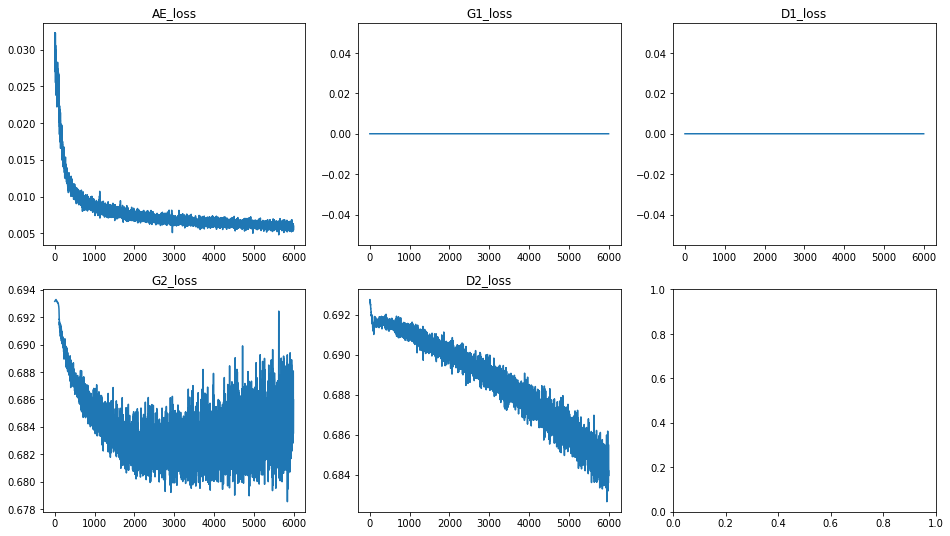

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(16,9))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G1_loss"], label="G1_loss")
ax[0, 1].set_title("G1_loss")

ax[0, 2].plot(range(n_epochs-1), history["D1_loss"], label="D1_loss")
ax[0, 2].set_title("D1_loss")

ax[1, 0].plot(range(n_epochs-1), history["G2_loss"], label="G2_loss")
ax[1, 0].set_title("G2_loss")

ax[1, 1].plot(range(n_epochs-1), history["D2_loss"], label="D2_loss")
ax[1, 1].set_title("D2_loss")

plt.show()

In [93]:
image = train_set[-38].reshape((1,48,96,96,1))
model.autoencoder.load_weights(r'../GAN_log/autoencoder_epoch_5629.h5')
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

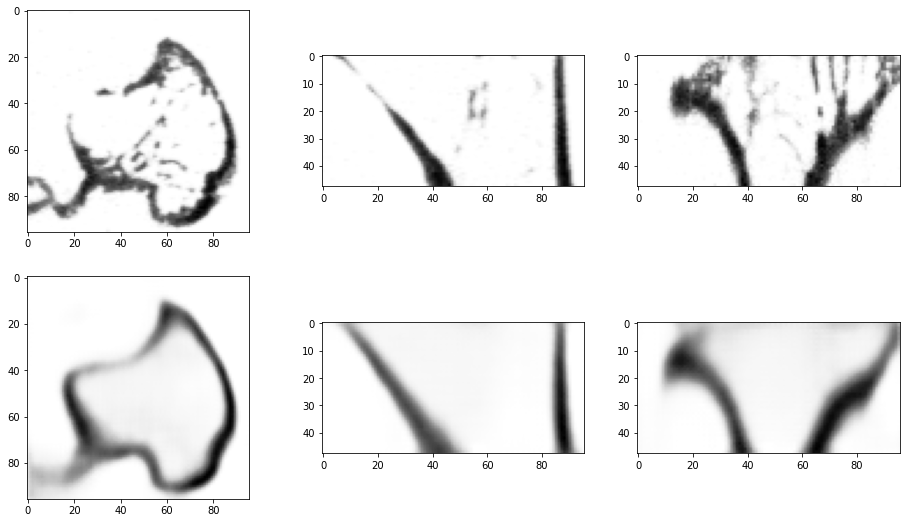

In [94]:
fig2, ax = plt.subplots(2,3, figsize=(16,9))
ax[0,0].imshow(image[35,:,:],cmap="Greys")
ax[1,0].imshow(gen_image[35,:,:],cmap="Greys")
ax[0,1].imshow(image[::-1,50,:],cmap="Greys")
ax[1,1].imshow(gen_image[::-1,50,:],cmap="Greys")
ax[0,2].imshow(image[::-1,:,60],cmap="Greys")
ax[1,2].imshow(gen_image[::-1,:,60],cmap="Greys")

In [75]:
#model = AAE(encoded_dim=256)
model.encoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_96 (Conv3D)           (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 24, 48, 48, 16)    6928      
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 12, 24, 24, 32)    27680     
_________________________________________________________________
conv3d_100 (Conv3D)          (None, 12, 24, 24, 64)    55360     
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 6, 12, 12, 64)     110656    
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 6, 12, 12, 128)  

In [74]:
model.decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_100 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_101 (Dense)            (None, 13824)             3552768   
_________________________________________________________________
reshape_8 (Reshape)          (None, 3, 6, 6, 128)      0         
_________________________________________________________________
conv3d_transpose_56 (Conv3DT (None, 3, 6, 6, 64)       221248    
_________________________________________________________________
conv3d_transpose_57 (Conv3DT (None, 6, 12, 12, 64)     110656    
_________________________________________________________________
conv3d_transpose_58 (Conv3DT (None, 6, 12, 12, 32)   

In [44]:
model.discriminator2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_103 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 12, 24, 24, 32)    0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 12, 24, 24, 64)  

In [52]:
for layer in model.generator.layers:
    print(layer.trainable)

True
True
True


In [57]:
model.generator2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_50 (Sequential)   (None, 48, 96, 96, 1)     2219409   
_________________________________________________________________
sequential_52 (Sequential)   (None, 1)                 69729     
Total params: 2,219,409
Trainable params: 2,219,409
Non-trainable params: 0
_________________________________________________________________
